### Settings

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/workspace-test1/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.helpers.oldModelUtilities as oldmodels
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import BFmethod
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cpu


In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 32

imageType = "shapes_3_dims_24_4" #10x10 triangle in 16x16 matrix shapes_3_dims_10_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7

testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/test_images_32x32.npy')
print(testSample.shape) #Total unique images: 31 449 200

(500, 32, 32)


# Functions used for testing

## Visualisation of Embeddings

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
########### Preprocess Input Data ###########
testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/test_images_56x56.npy')
testSample = testSample[:500]
print(testSample.shape)
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset).to(device) 
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

(500, 56, 56)


In [27]:
########### Load Model ###########
model_directory = "model/all_model_dumps_1"
imageType = "shapes_3_dims_48_4"
dim = 64
embeddingType = f"pencorr_{dim}"

model = SimpleCNN4(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                 f'best_model_{imageType}_{dim}d_convlayer3.pt'), weights_only=True, map_location=torch.device('cpu')))

model.eval()
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model, device)
model_vectors_np = np.array([emb.detach().numpy() for emb in model_vectors]).squeeze()

printing results for 64
3 clusters


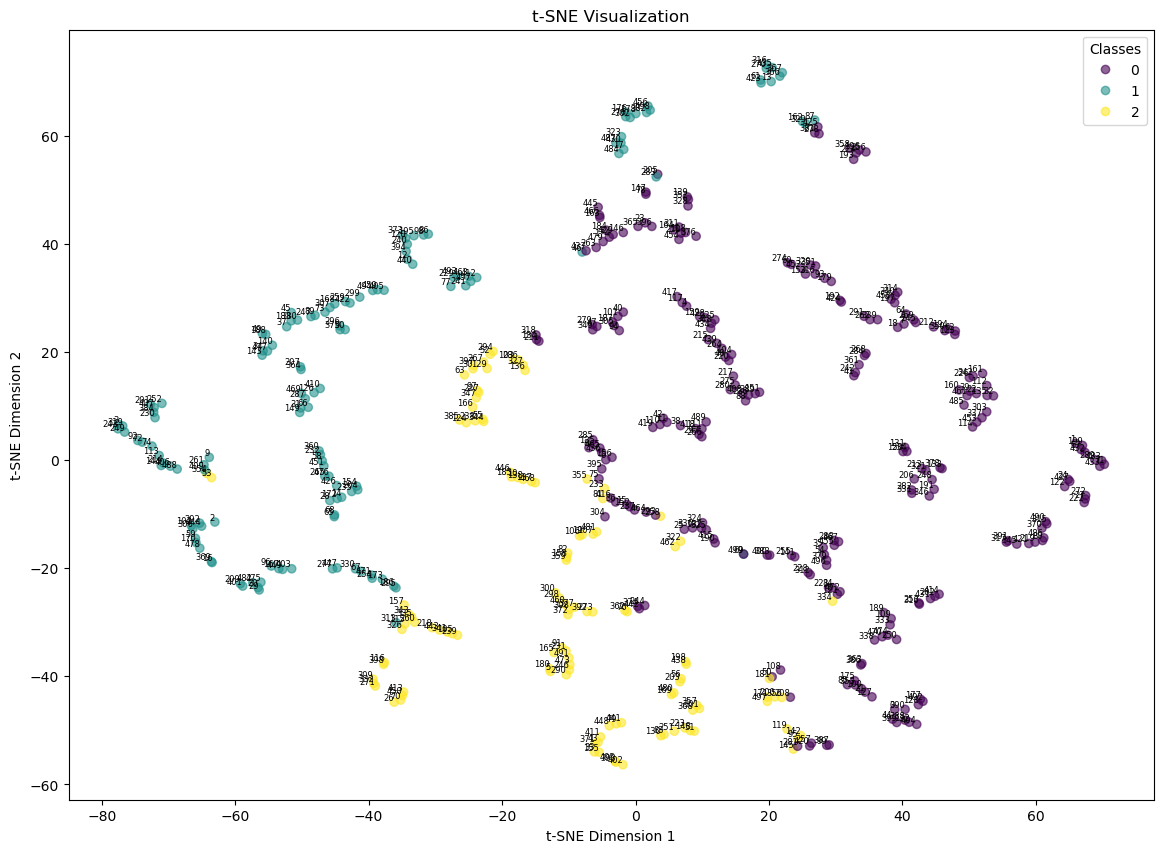

Reduced from 64D to 32D while preserving 99.0% variance


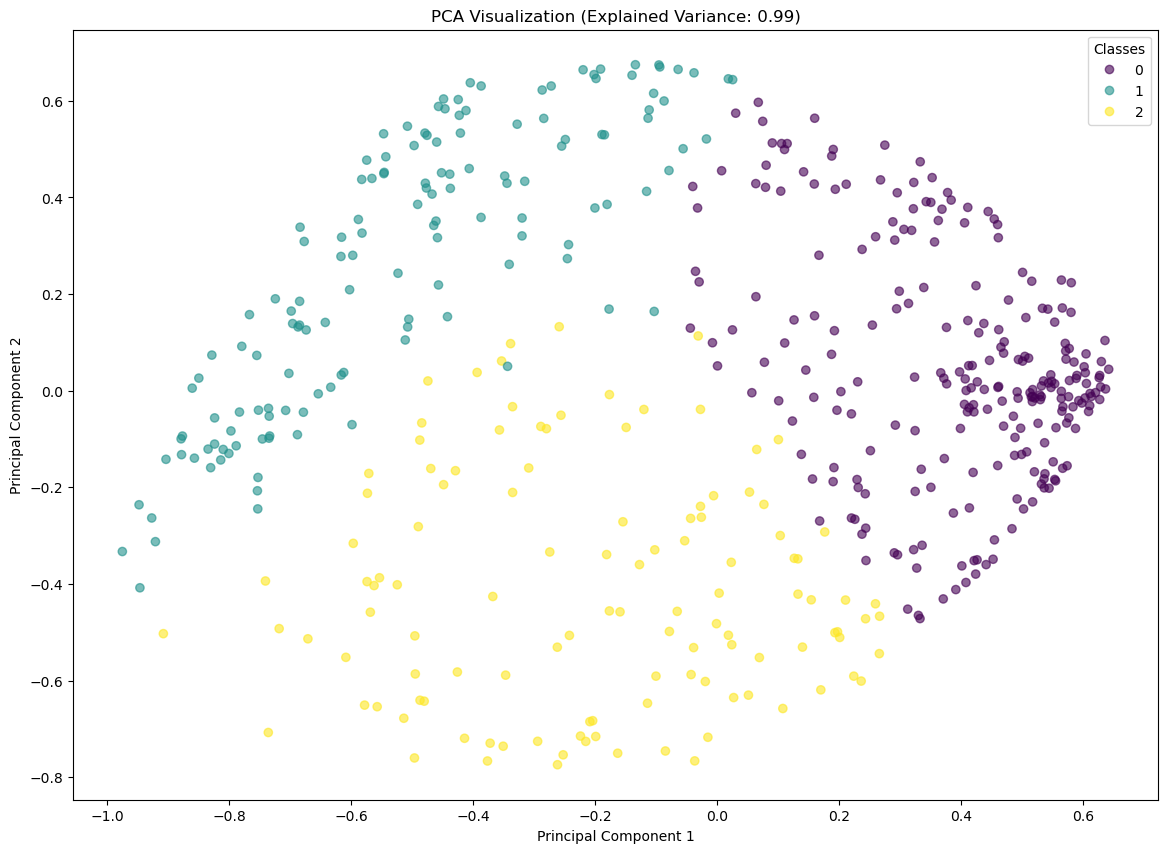

In [8]:
########### Visualisation ###########
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

def visualize_pca(embeddings, labels=None):
    """
    Visualize embeddings using PCA
    :param embeddings: List/numpy array of model embeddings (num_samples x embedding_dim)
    :param labels: Optional list of labels for color coding
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    n_components_value = 0.99
    pca = PCA(n_components = n_components_value)  # Keep components explaining 95% variance
    reduced_features = pca.fit_transform(model_vectors_np)

    print(f"Reduced from {dim}D to {reduced_features.shape[1]}D while preserving {n_components_value*100}% variance")
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Add index labels to each point
    # for i, (x, y) in enumerate(reduced_features[:, :2]):
    #     plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
    
    plt.title(f'PCA Visualization (Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

def visualize_tsne(embeddings, labels=None, perplexity=5):
    """
    Visualize embeddings using t-SNE
    :param embeddings: List/numpy array of model embeddings
    :param labels: Optional list of labels for color coding
    :param perplexity: Measure of the "effective number of neighbors" for each data point
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
        # Add index labels to each point
    for i, (x, y) in enumerate(reduced[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
        
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

#########################################
dimensions = [64]
model_directory = "model/all_model_dumps_1"
imageType = "shapes_3_dims_48_4"
for dim in dimensions:
    print(f"printing results for {dim}")
    model = oldmodels.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer5.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model, device)
    model_vectors_np = np.array([emb.detach().numpy() for emb in model_vectors]).squeeze()
    
#     print("5 clusters")
#     kmeans = KMeans(n_clusters=5, random_state=42) #creating labels through clustering
#     cluster_labels = kmeans.fit_predict(model_vectors_np)

#     visualize_tsne(model_vectors_np, labels=cluster_labels)
#     visualize_pca(model_vectors_np, labels=cluster_labels)
    
        
#     print("4 clusters")
    
#     kmeans = KMeans(n_clusters=4, random_state=42)
#     cluster_labels = kmeans.fit_predict(model_vectors_np)

#     visualize_tsne(model_vectors_np, labels=cluster_labels)
#     visualize_pca(model_vectors_np, labels=cluster_labels)
    
    print("3 clusters")
    kmeans = KMeans(n_clusters=3, random_state=42) #creating labels through clustering
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)

printing results for 64
5 clusters


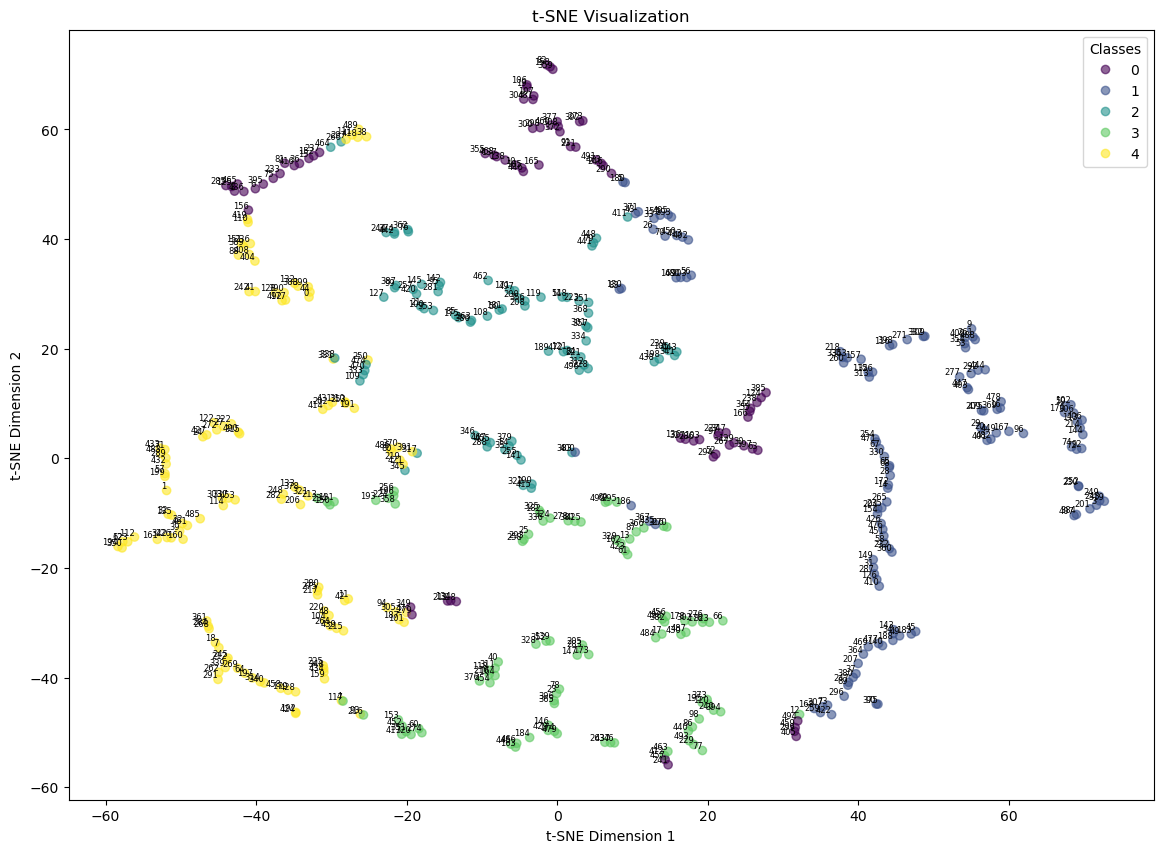

Reduced from 64D to 30D while preserving 99.0% variance


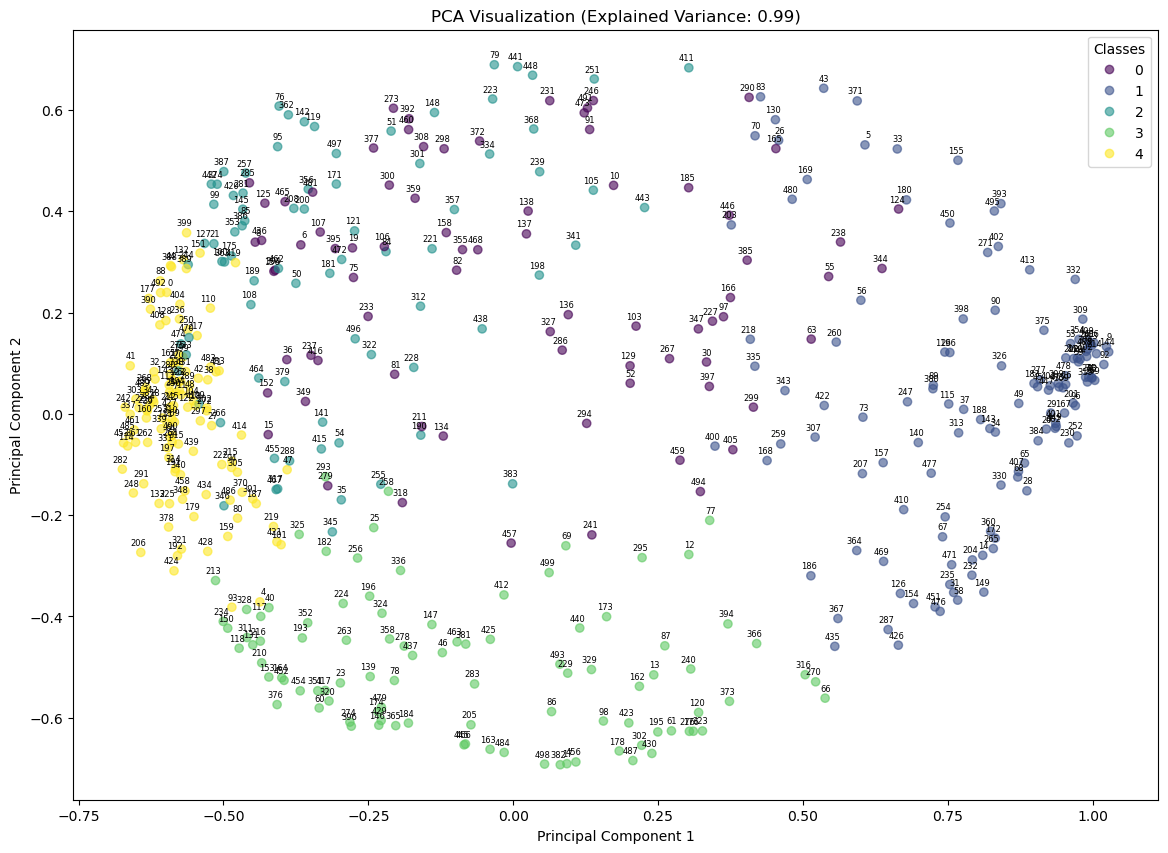

4 clusters


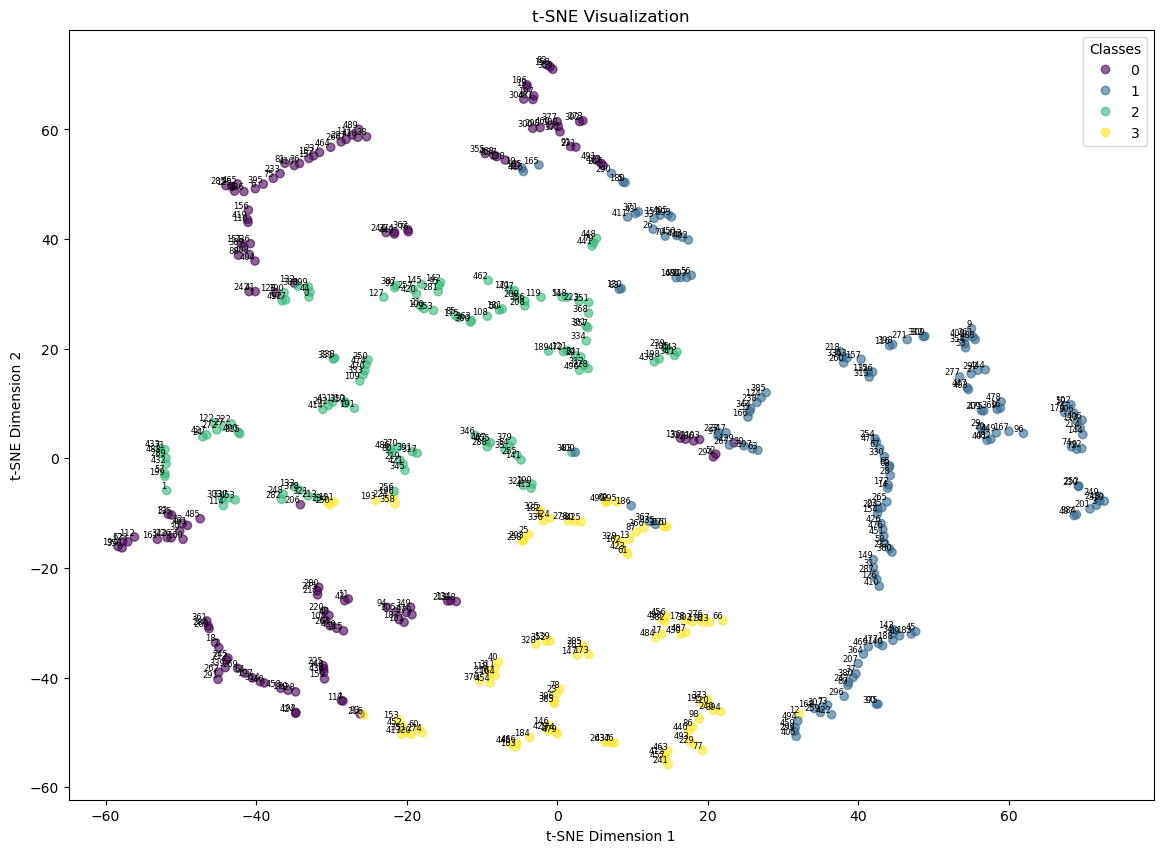

Reduced from 64D to 30D while preserving 99.0% variance


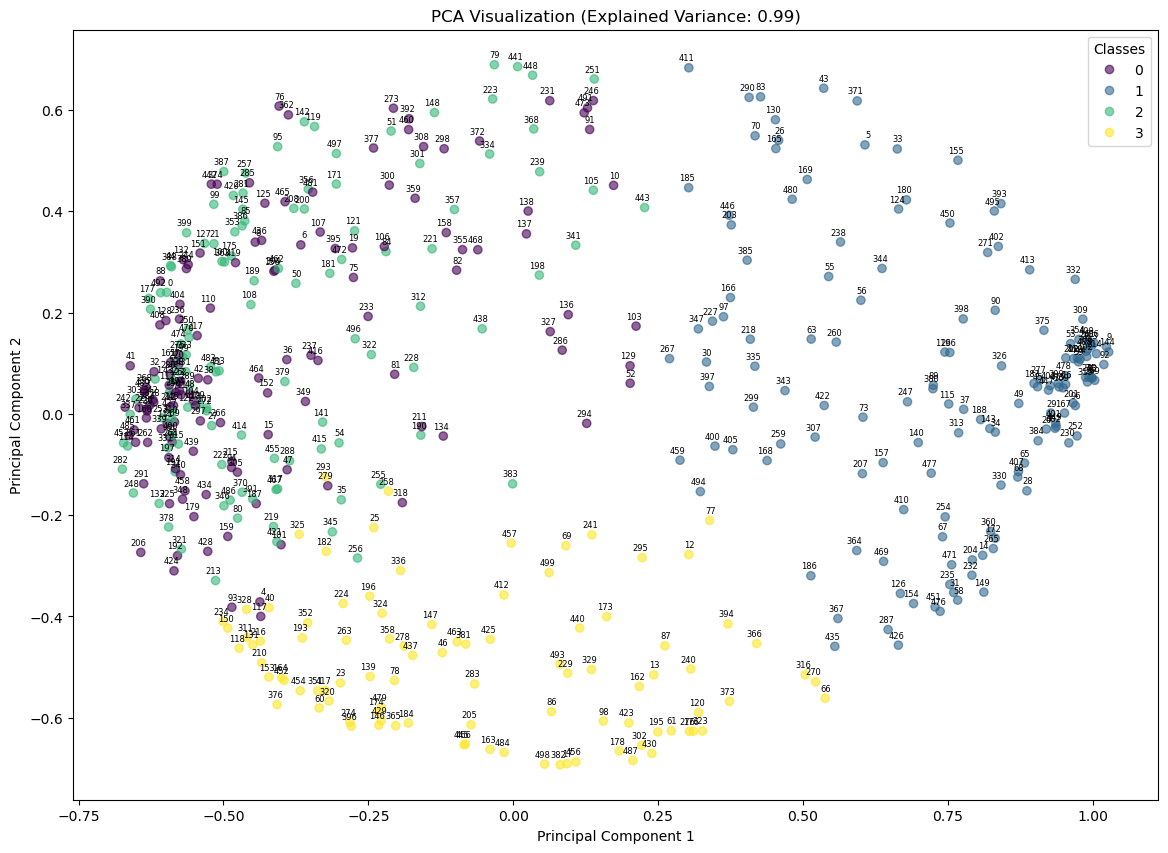

3 clusters


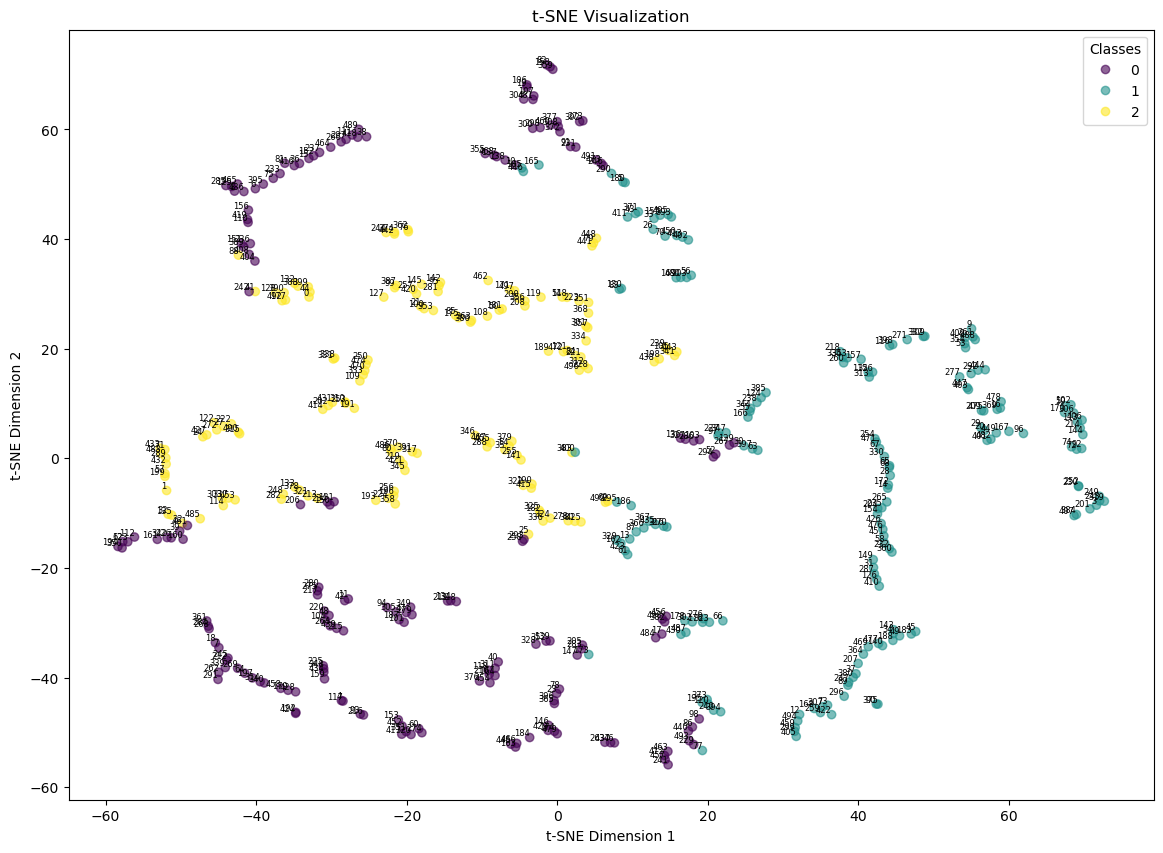

Reduced from 64D to 30D while preserving 99.0% variance


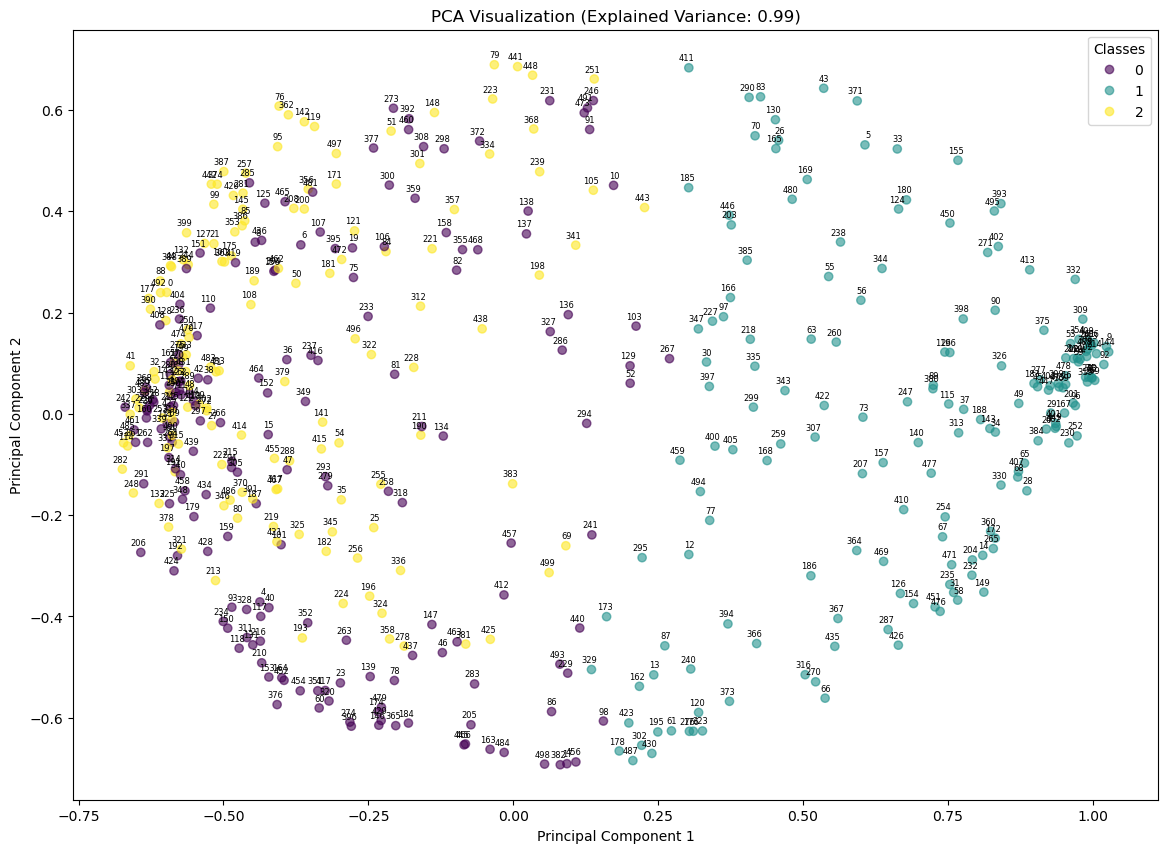

In [7]:
########### Visualisation ###########
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

def visualize_pca(embeddings, labels=None):
    """
    Visualize embeddings using PCA
    :param embeddings: List/numpy array of model embeddings (num_samples x embedding_dim)
    :param labels: Optional list of labels for color coding
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    n_components_value = 0.99
    pca = PCA(n_components = n_components_value)  # Keep components explaining 95% variance
    reduced_features = pca.fit_transform(model_vectors_np)

    print(f"Reduced from {dim}D to {reduced_features.shape[1]}D while preserving {n_components_value*100}% variance")
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Add index labels to each point
    for i, (x, y) in enumerate(reduced_features[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
    
    plt.title(f'PCA Visualization (Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

def visualize_tsne(embeddings, labels=None, perplexity=5):
    """
    Visualize embeddings using t-SNE
    :param embeddings: List/numpy array of model embeddings
    :param labels: Optional list of labels for color coding
    :param perplexity: Measure of the "effective number of neighbors" for each data point
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
        # Add index labels to each point
    for i, (x, y) in enumerate(reduced[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
        
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

#########################################
dimensions = [64]
model_directory = "model/all_model_dumps_1"
imageType = "shapes_3_dims_48_4"
for dim in dimensions:
    print(f"printing results for {dim}")
    model = oldmodels.SimpleCNN4(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer3.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model, device)
    model_vectors_np = np.array([emb.detach().numpy() for emb in model_vectors]).squeeze()
    
    print("5 clusters")
    kmeans = KMeans(n_clusters=5, random_state=42) #creating labels through clustering
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)
    
        
    print("4 clusters")
    
    kmeans = KMeans(n_clusters=4, random_state=42)
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)
    
    print("3 clusters")
    kmeans = KMeans(n_clusters=3, random_state=42) #creating labels through clustering
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)

Reduced from 32D to 12D while preserving 99.0% variance


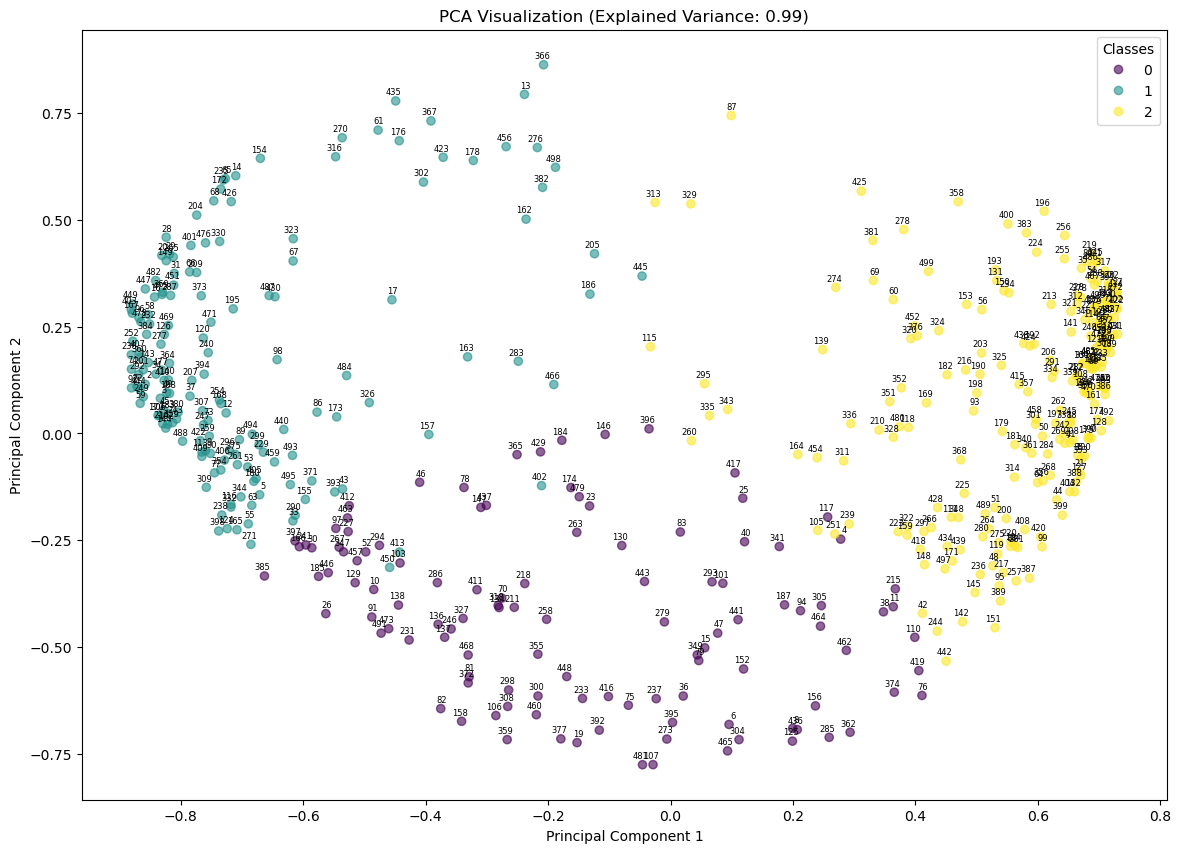

Reduced from 32D to 12D while preserving 99.0% variance

Subclusters in Cluster 0:
Point 8 is closest to: [436, 125, 304]
Point 10 is closest to: [138, 446, 185]
Point 11 is closest to: [38, 110, 215]
Point 30 is closest to: [397, 166, 267]
Point 52 is closest to: [294, 267, 103]
Point 75 is closest to: [233, 395, 416]
Point 97 is closest to: [227, 347, 267]
Point 103 is closest to: [52, 286, 347]
Point 125 is closest to: [285, 436, 8]
Point 129 is closest to: [267, 347, 30]
Point 136 is closest to: [327, 137, 468]
Point 137 is closest to: [468, 136, 138]
Point 166 is closest to: [30, 397, 446]
Point 185 is closest to: [446, 166, 10]
Point 187 is closest to: [305, 101, 94]
Point 227 is closest to: [97, 347, 267]
Point 267 is closest to: [347, 52, 30]
Point 286 is closest to: [327, 103, 136]
Point 294 is closest to: [52, 103, 267]
Point 298 is closest to: [308, 300, 460]
Point 305 is closest to: [94, 187, 215]
Point 308 is closest to: [460, 298, 372]
Point 327 is closest to: [136, 286, 

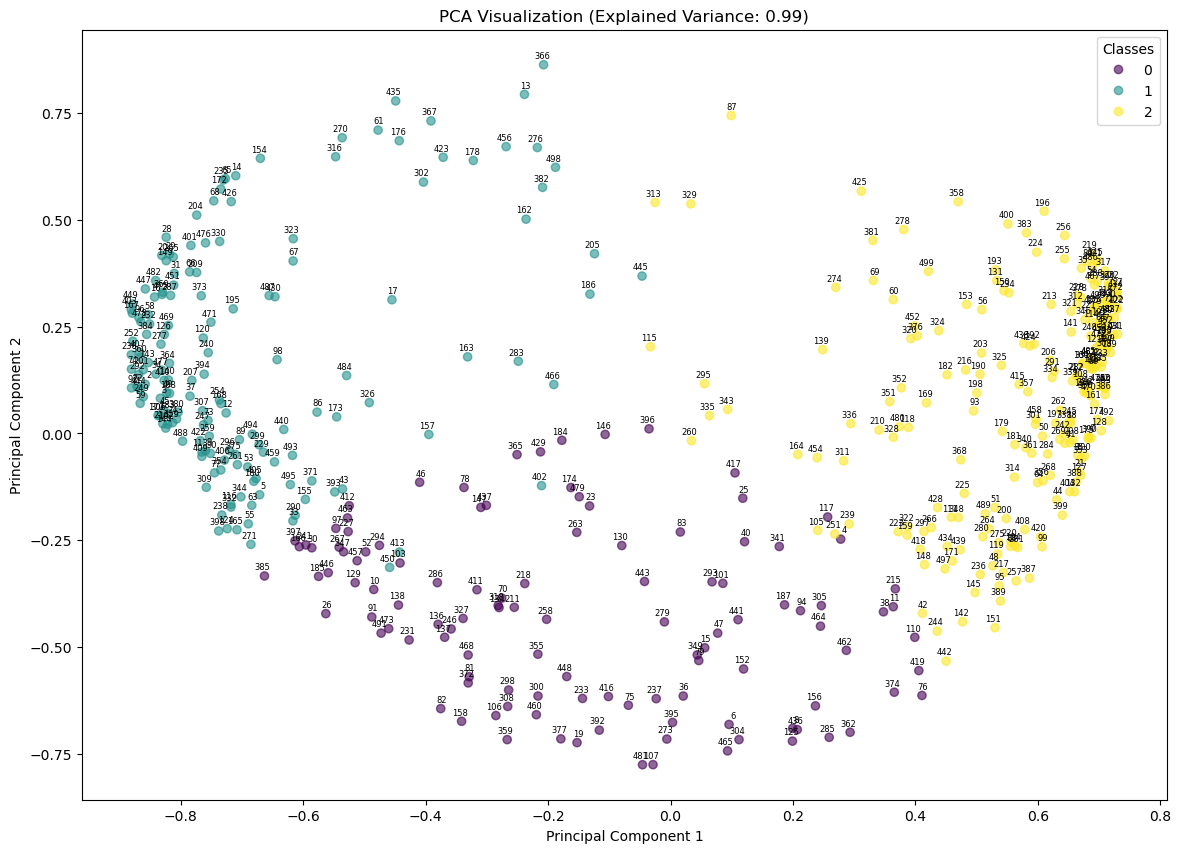

In [7]:
from sklearn.neighbors import NearestNeighbors

def visualize_pca(embeddings, labels=None, find_subclusters=False, k=5):
    """
    Visualize embeddings using PCA with subcluster identification
    :param embeddings: List/numpy array of model embeddings
    :param labels: Optional list of labels for color coding
    :param find_subclusters: Whether to identify subclusters
    :param k: Number of nearest neighbors to consider
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    n_components_value = 0.99
    pca = PCA(n_components=n_components_value)
    reduced_features = pca.fit_transform(embeddings)  # Use embeddings instead of model_vectors_np

    print(f"Reduced from {embeddings.shape[1]}D to {reduced_features.shape[1]}D while preserving {n_components_value*100}% variance")
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Add index labels to each point
    for i, (x, y) in enumerate(reduced_features[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
    
    # Find subclusters if requested
    if find_subclusters and labels is not None:
        unique_labels = np.unique(labels)
        subcluster_results = {}
        
        for label in unique_labels:
            # Get points for this cluster
            cluster_indices = np.where(labels == label)[0]
            cluster_points = reduced_features[cluster_indices]
            
            if len(cluster_points) > k:
                nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(cluster_points)
                distances, indices = nbrs.kneighbors(cluster_points)
                
                avg_distances = np.mean(distances[:, 1:], axis=1) 
                threshold = np.percentile(avg_distances, 25) 
                subcluster_local_indices = np.where(avg_distances < threshold)[0]
                
                subcluster_indices = cluster_indices[subcluster_local_indices]
                
                subcluster_results[f"Cluster {label}"] = {
                    "subcluster_indices": subcluster_indices,
                    "local_indices": subcluster_local_indices,
                    "neighbor_indices": indices
                }
                
                print(f"\nSubclusters in Cluster {label}:")
                for i, idx in enumerate(subcluster_local_indices):
                    original_idx = cluster_indices[idx]
                    neighbors = indices[idx][1:4]  # Skip self, get next 3
                    neighbor_original = [cluster_indices[n] for n in neighbors]
                    print(f"Point {original_idx} is closest to: {neighbor_original}")
    
    plt.title(f'PCA Visualization (Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()
    
    if find_subclusters and labels is not None:
        return subcluster_results
    return None

# Just visualize
visualize_pca(model_vectors_np, labels=cluster_labels)

# Find subclusters with 5 nearest neighbors
subclusters = visualize_pca(model_vectors_np, labels=cluster_labels, find_subclusters=True, k=5)

Reduced from 32D to 12D while preserving 99.0% variance

Points close to different clusters (by class pair):

Class 0 points close to Class 1:
Point 397 (Class 0) is close to: 405 (Class 1, dist=0.192), 63 (Class 1, dist=0.213)
Point 412 (Class 0) is close to: 493 (Class 1, dist=0.197), 229 (Class 1, dist=0.247), 440 (Class 1, dist=0.272)
Point 166 (Class 0) is close to: 63 (Class 1, dist=0.212)
Point 463 (Class 0) is close to: 493 (Class 1, dist=0.222), 229 (Class 1, dist=0.233), 86 (Class 1, dist=0.275)
Point 184 (Class 0) is close to: 466 (Class 1, dist=0.234), 163 (Class 1, dist=0.286)

Class 0 points close to Class 2:
Point 110 (Class 0) is close to: 42 (Class 2, dist=0.091), 217 (Class 2, dist=0.228), 48 (Class 2, dist=0.229)
Point 11 (Class 0) is close to: 42 (Class 2, dist=0.106), 439 (Class 2, dist=0.199), 48 (Class 2, dist=0.241)
Point 341 (Class 0) is close to: 105 (Class 2, dist=0.148), 239 (Class 2, dist=0.267), 322 (Class 2, dist=0.362)
Point 215 (Class 0) is close to: 15

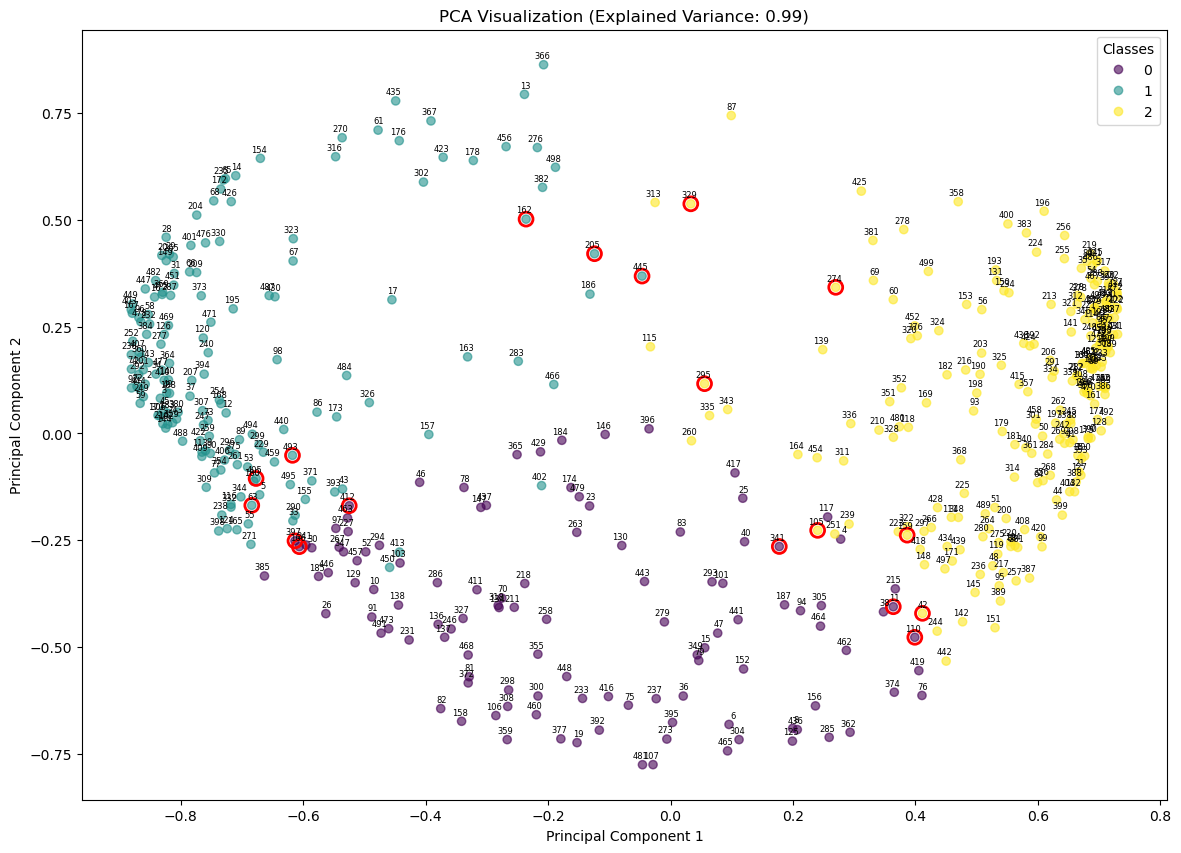

In [10]:
from sklearn.neighbors import NearestNeighbors

def visualize_pca(embeddings, labels=None, find_cross_cluster=False, k=5):
    """
    Visualize embeddings using PCA and identify points close to other clusters
    :param embeddings: List/numpy array of model embeddings
    :param labels: Optional list of labels for color coding
    :param find_cross_cluster: Whether to identify points close to other clusters
    :param k: Number of nearest neighbors to consider
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    n_components_value = 0.99
    pca = PCA(n_components=n_components_value)
    reduced_features = pca.fit_transform(embeddings)

    print(f"Reduced from {embeddings.shape[1]}D to {reduced_features.shape[1]}D while preserving {n_components_value*100}% variance")
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Add index labels to each point
    for i, (x, y) in enumerate(reduced_features[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
    
    # Find points close to different clusters
    if find_cross_cluster and labels is not None:
        # Find nearest neighbors for all points
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(reduced_features)
        distances, indices = nbrs.kneighbors(reduced_features)

        # Find points whose neighbors are in different clusters
        cross_cluster_points = []

        # Get unique class pairs
        unique_labels = np.unique(labels)
        class_pairs = [(a, b) for a in unique_labels for b in unique_labels if a != b]

        # For each class pair, find the closest points
        pair_results = {}
        for class_a, class_b in class_pairs:
            pair_cross_points = []

            # Check points in class A with neighbors in class B
            for i in np.where(labels == class_a)[0]:
                current_label = labels[i]
                neighbor_indices = indices[i][1:]  # Skip self

                # Find neighbors with class B label
                class_b_neighbors = [(idx, labels[idx], distances[i][j+1]) 
                                   for j, idx in enumerate(neighbor_indices) 
                                   if labels[idx] == class_b]

                if class_b_neighbors:
                    # Sort by distance
                    class_b_neighbors.sort(key=lambda x: x[2])
                    pair_cross_points.append((i, current_label, class_b_neighbors[:3]))

            # Sort by distance
            pair_cross_points.sort(key=lambda x: x[2][0][2] if x[2] else float('inf'))
            pair_results[(class_a, class_b)] = pair_cross_points[:5]  # Top 5 for each pair

        # Print results for each class pair
        print("\nPoints close to different clusters (by class pair):")
        for (class_a, class_b), points in pair_results.items():
            print(f"\nClass {class_a} points close to Class {class_b}:")
            for point_idx, point_label, neighbors in points:
                neighbor_str = ", ".join([f"{idx} (Class {label}, dist={dist:.3f})" 
                                         for idx, label, dist in neighbors])
                print(f"Point {point_idx} (Class {point_label}) is close to: {neighbor_str}")

        # Highlight cross-cluster points on the plot (top 3 from each pair)
        highlight_points = []
        for points in pair_results.values():
            highlight_points.extend([p[0] for p in points[:3]])

        plt.scatter(reduced_features[highlight_points, 0], reduced_features[highlight_points, 1], 
                   s=100, facecolors='none', edgecolors='red', linewidths=2)

    
    plt.title(f'PCA Visualization (Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()
    
    if find_cross_cluster and labels is not None:
        return cross_cluster_points
    return None

# Find points close to different clusters
cross_points = visualize_pca(model_vectors_np, labels=cluster_labels, find_cross_cluster=True, k=10)


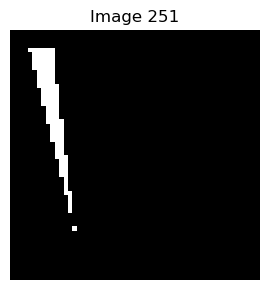

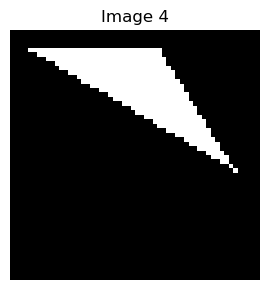

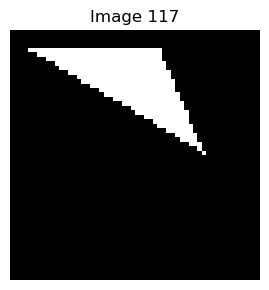

In [23]:
def plot_images(dataset, indices):
    for i in indices: 
        image = dataset[i]
        plt.figure(figsize=(5, 3))
        plt.imshow(image, cmap='gray', interpolation='nearest')
        plt.title(f"Image {i}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/test_images_56x56.npy')
testSample = testSample[:500]
indices = [251, 4, 117]

plot_images(testSample, indices)

printing results for 32
3 clusters


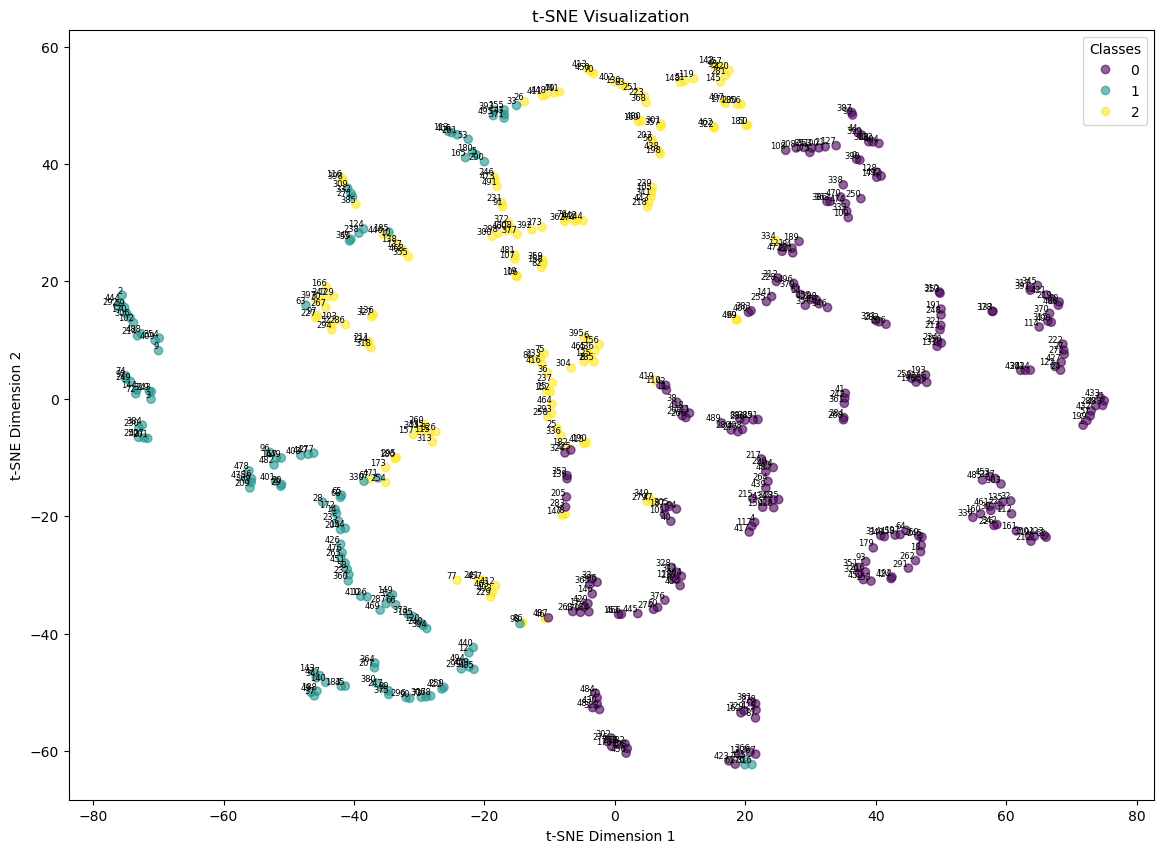

Reduced from 32D to 31D while preserving 99.0% variance


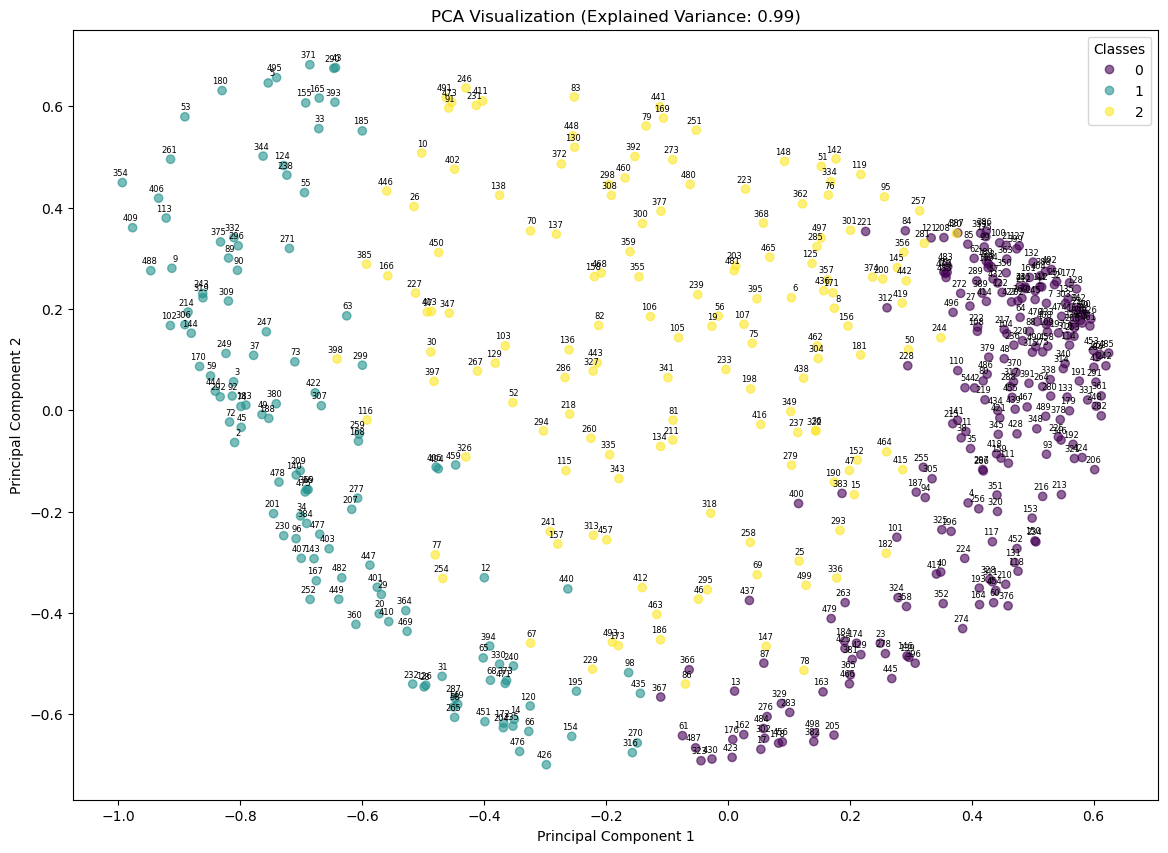

4 clusters


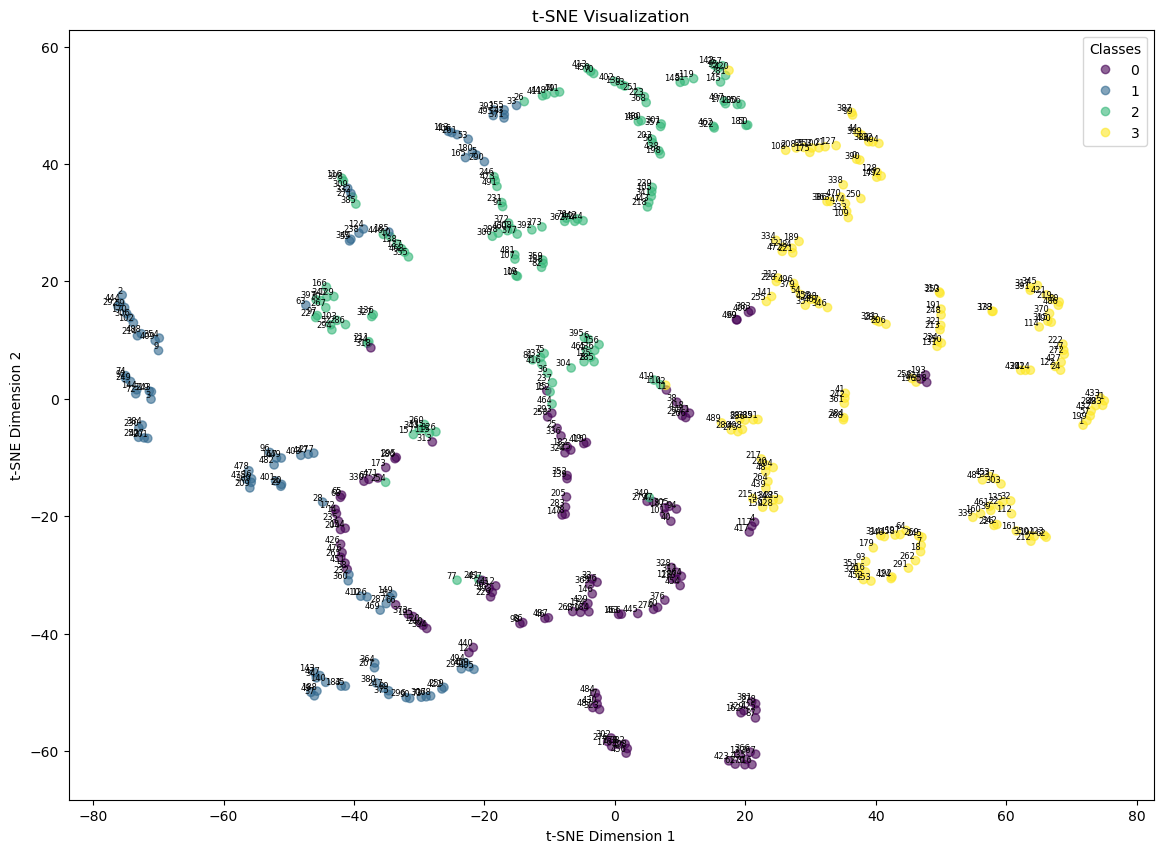

Reduced from 32D to 31D while preserving 99.0% variance


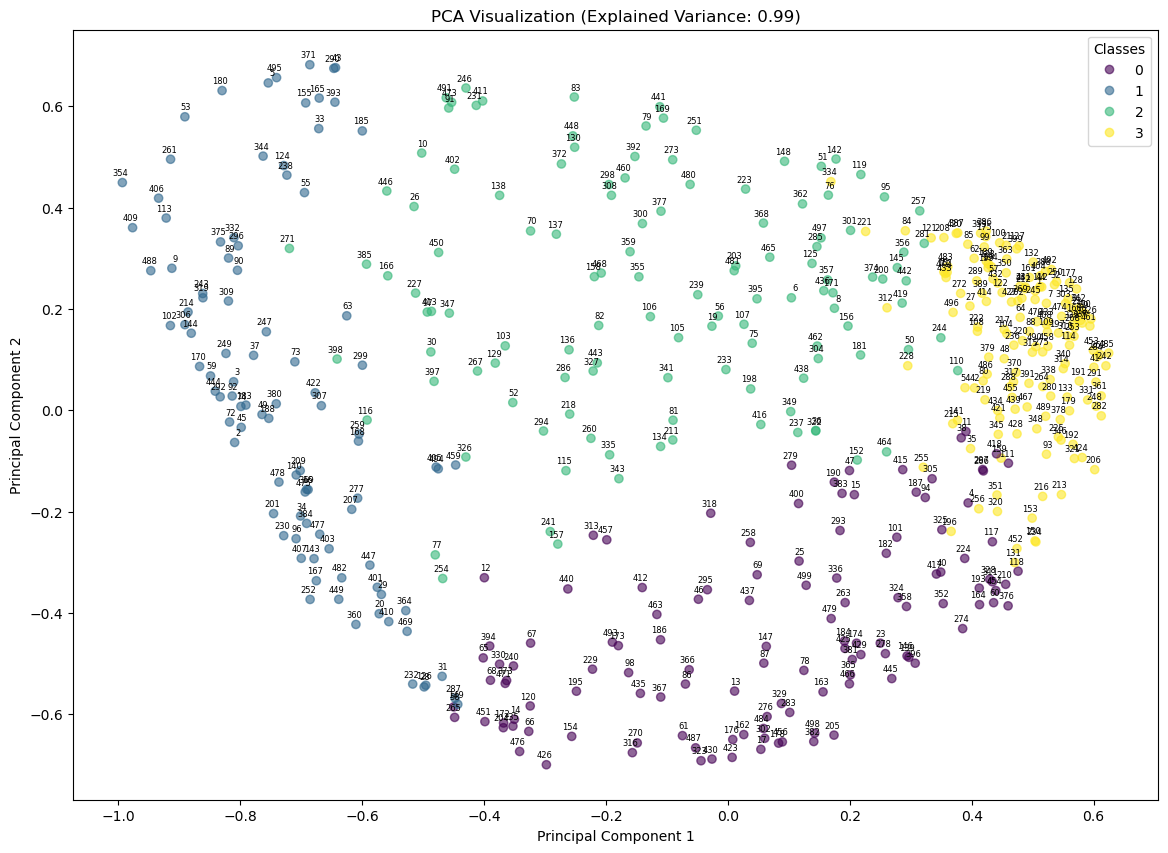

5 clusters


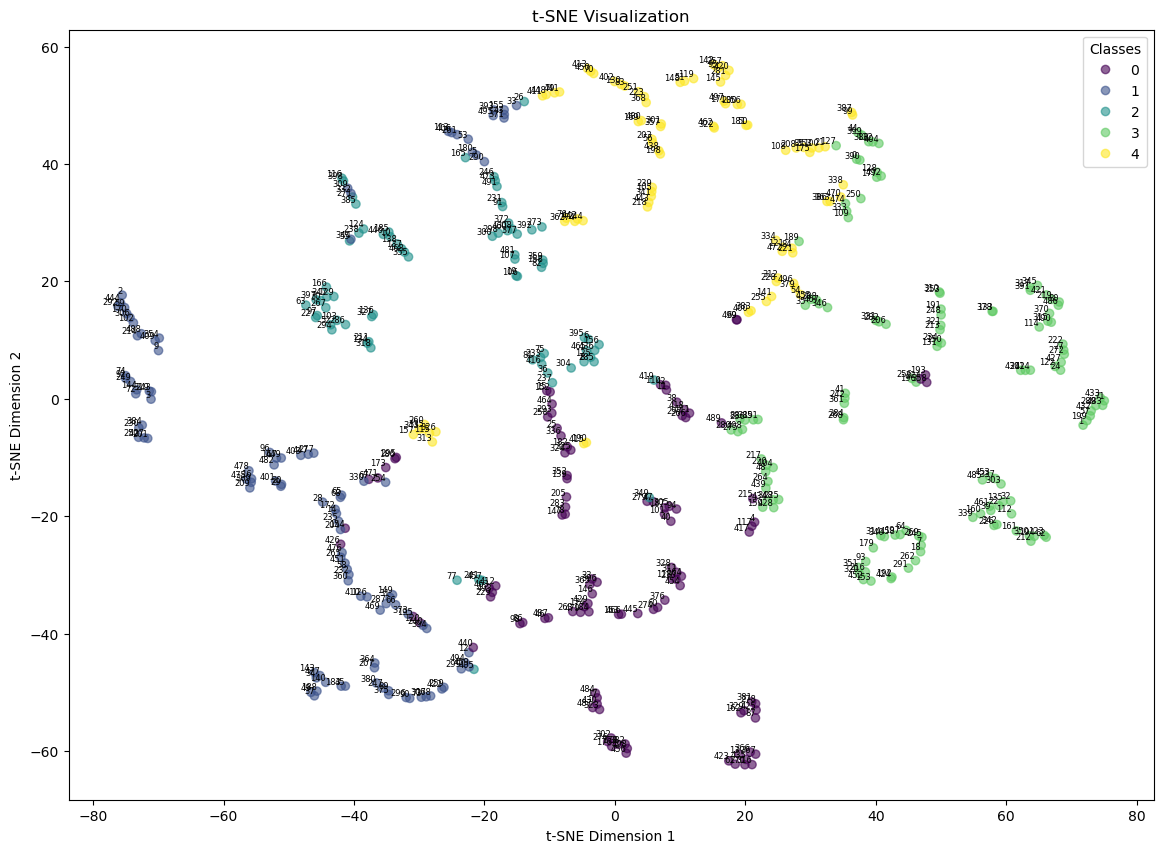

Reduced from 32D to 31D while preserving 99.0% variance


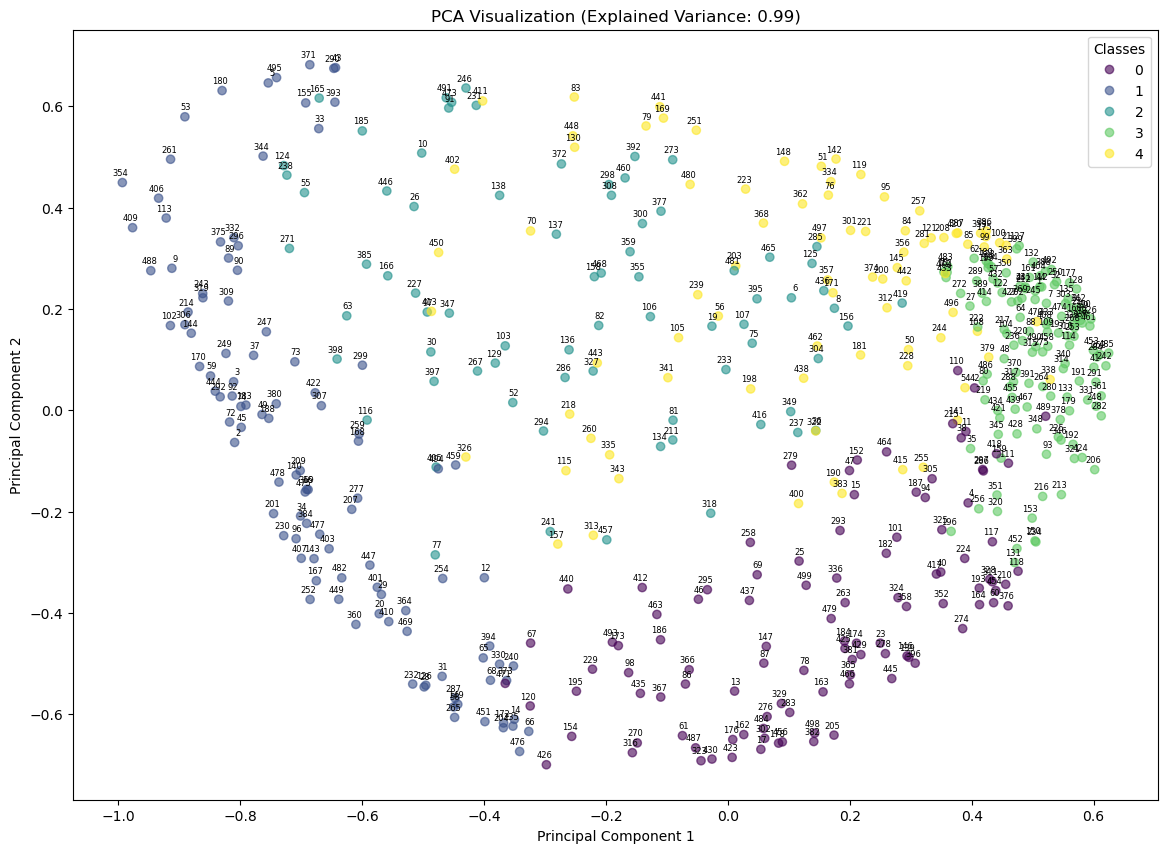

printing results for 64
3 clusters


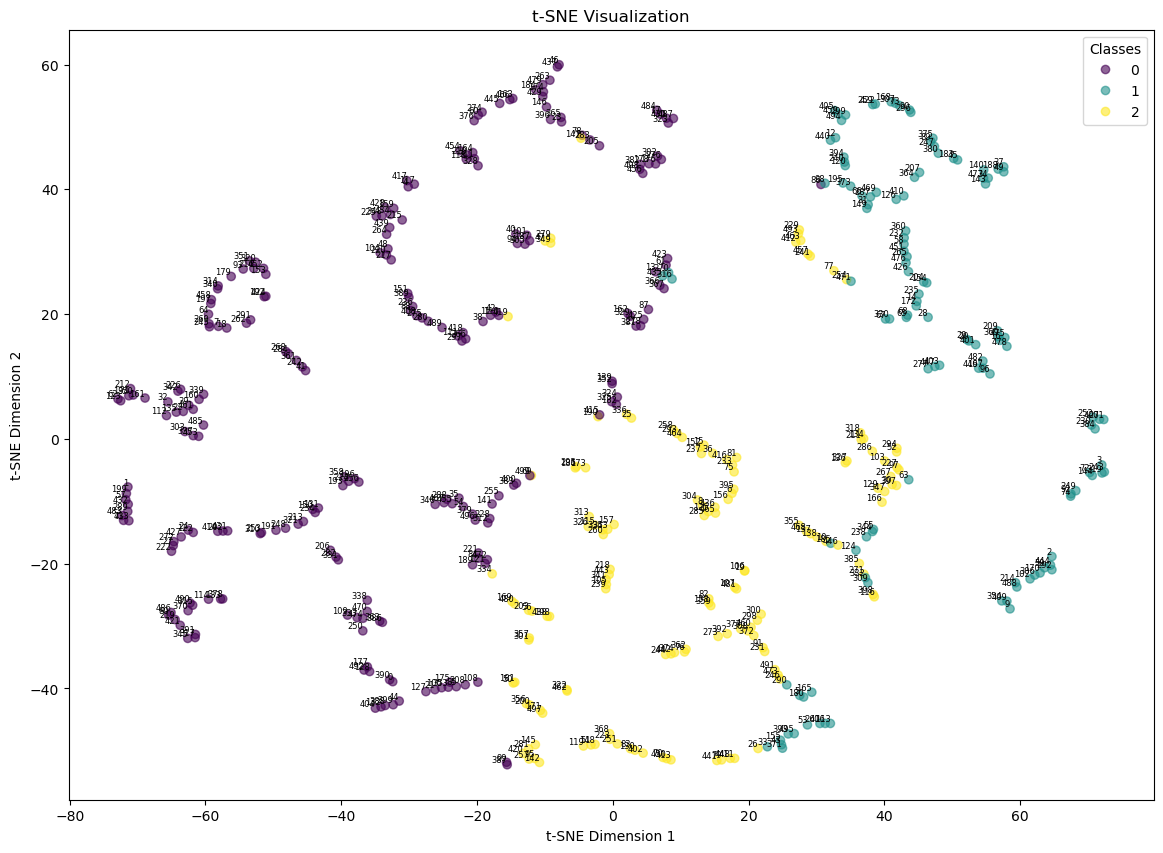

Reduced from 64D to 59D while preserving 99.0% variance


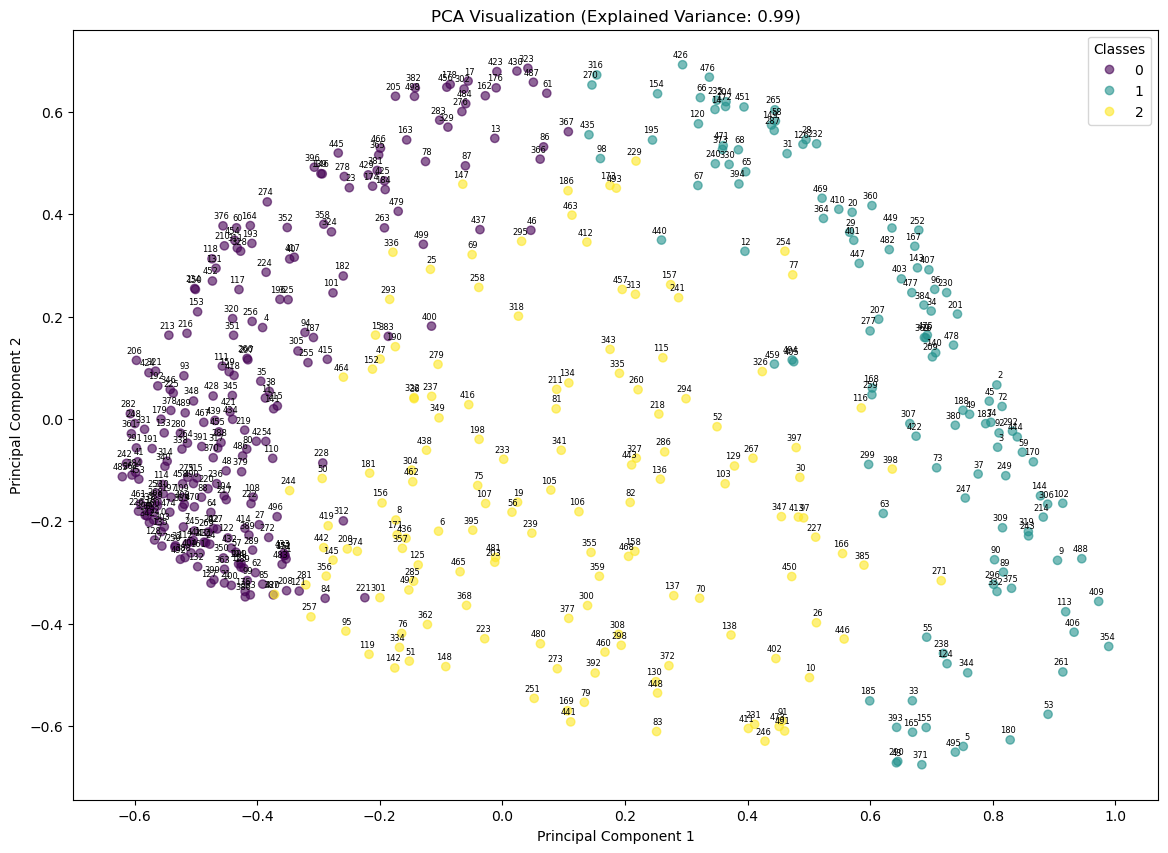

4 clusters


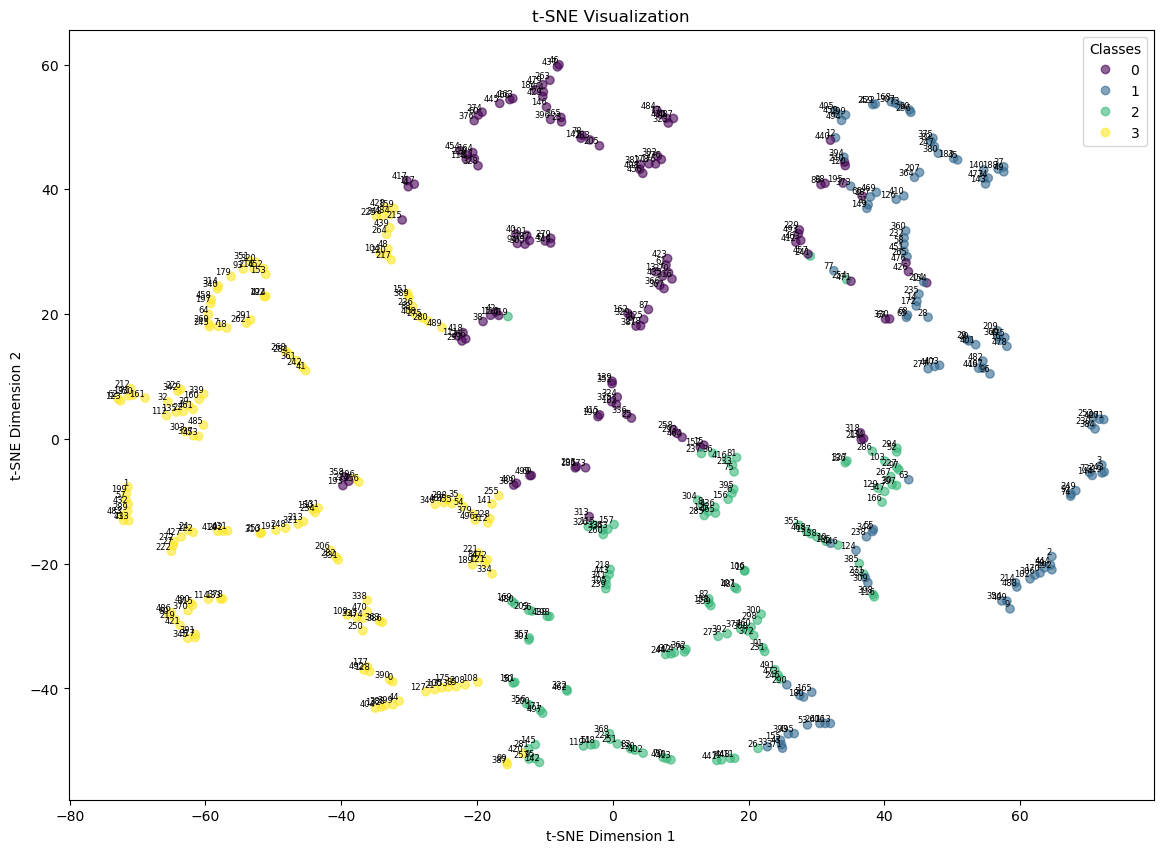

Reduced from 64D to 59D while preserving 99.0% variance


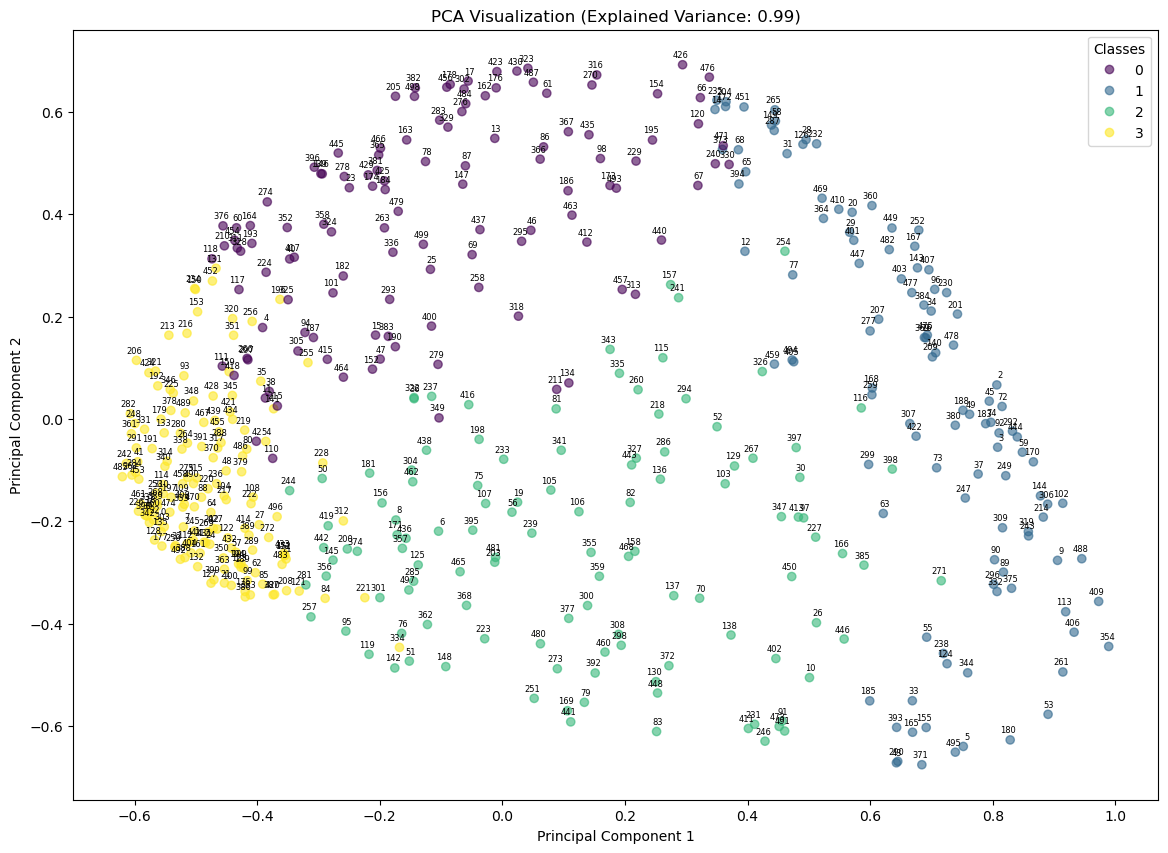

5 clusters


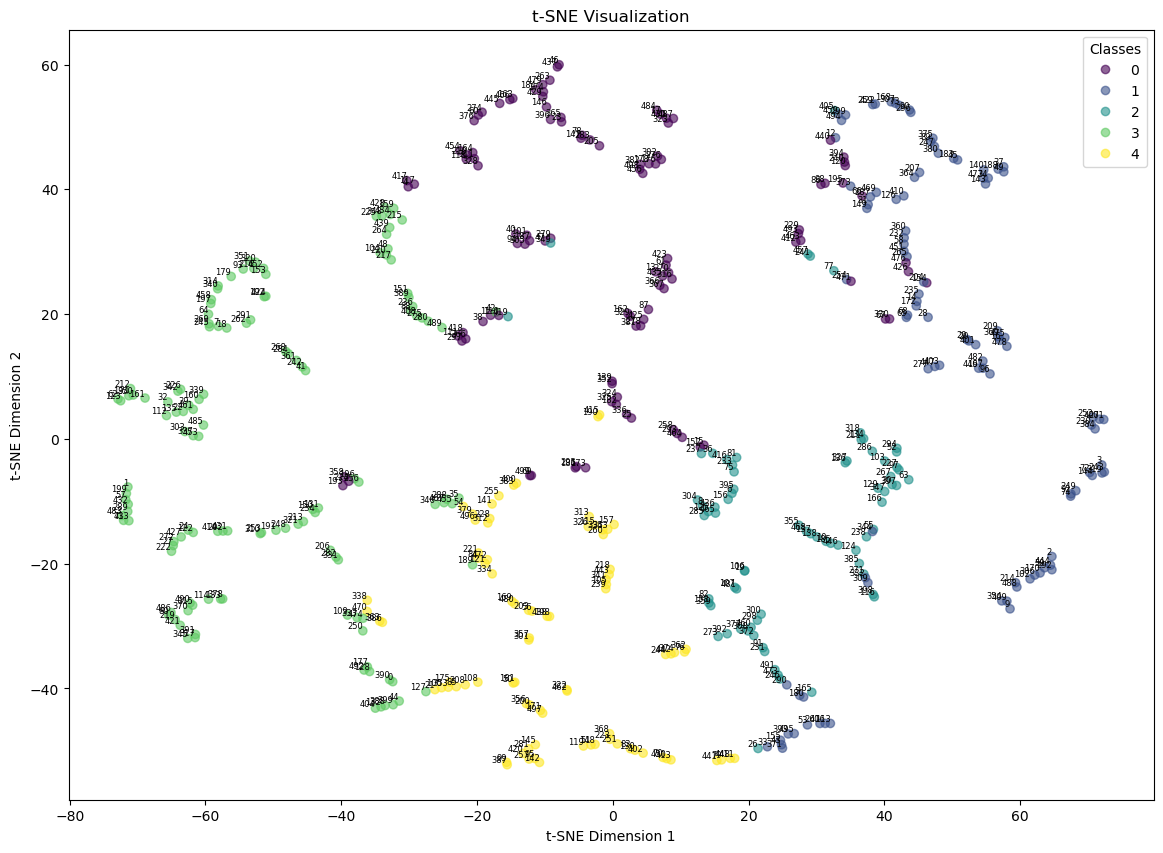

Reduced from 64D to 59D while preserving 99.0% variance


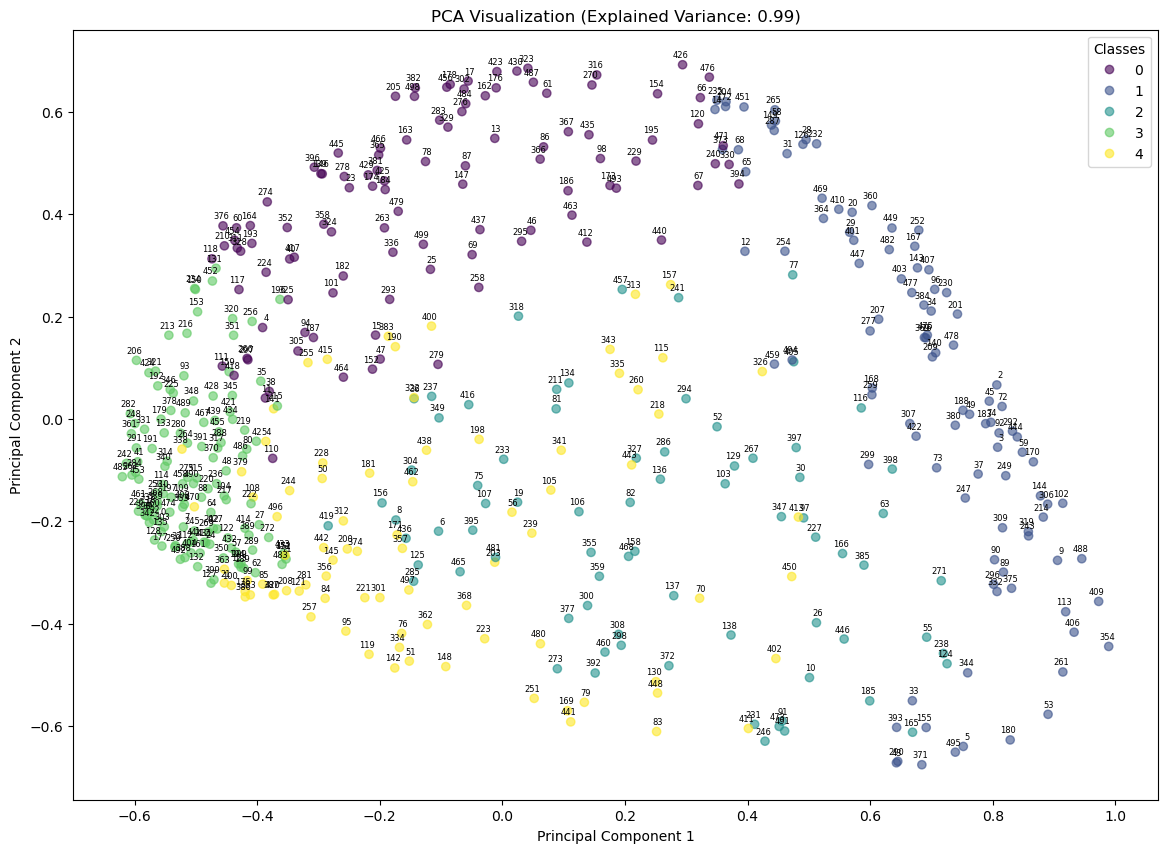

In [9]:
########### Visualisation ###########
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

def visualize_pca(embeddings, labels=None):
    """
    Visualize embeddings using PCA
    :param embeddings: List/numpy array of model embeddings (num_samples x embedding_dim)
    :param labels: Optional list of labels for color coding
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    n_components_value = 0.99
    pca = PCA(n_components = n_components_value)  # Keep components explaining 95% variance
    reduced_features = pca.fit_transform(model_vectors_np)

    print(f"Reduced from {dim}D to {reduced_features.shape[1]}D while preserving {n_components_value*100}% variance")
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
    # Add index labels to each point
    for i, (x, y) in enumerate(reduced_features[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
    
    plt.title(f'PCA Visualization (Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

def visualize_tsne(embeddings, labels=None, perplexity=5):
    """
    Visualize embeddings using t-SNE
    :param embeddings: List/numpy array of model embeddings
    :param labels: Optional list of labels for color coding
    :param perplexity: Measure of the "effective number of neighbors" for each data point
    """
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array([emb.detach().numpy() for emb in embeddings])
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    
        # Add index labels to each point
    for i, (x, y) in enumerate(reduced[:, :2]):
        plt.text(x + 0.01, y + 0.01, str(i), fontsize=6, ha='right', va='bottom')
        
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

#########################################
dimensions = [32, 64]
# model_directory = "model/all_model_dumps_1/LPS_models"
imageType = "shapes_3_dims_48_4"
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:
    print(f"printing results for {dim}")
    embeddingType = f"pencorr_{dim}"
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    embeddinglist = [matrixA[:, i].tolist() for i in range(matrixA.shape[1])]
    model_vectors_np = np.array(embeddinglist)
    
    print("3 clusters")
    kmeans = KMeans(n_clusters=3, random_state=42) #creating labels through clustering
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)
    
    print("4 clusters")
    kmeans = KMeans(n_clusters=4, random_state=42) #creating labels through clustering
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)
    
    print("5 clusters")
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(model_vectors_np)

    visualize_tsne(model_vectors_np, labels=cluster_labels)
    visualize_pca(model_vectors_np, labels=cluster_labels)


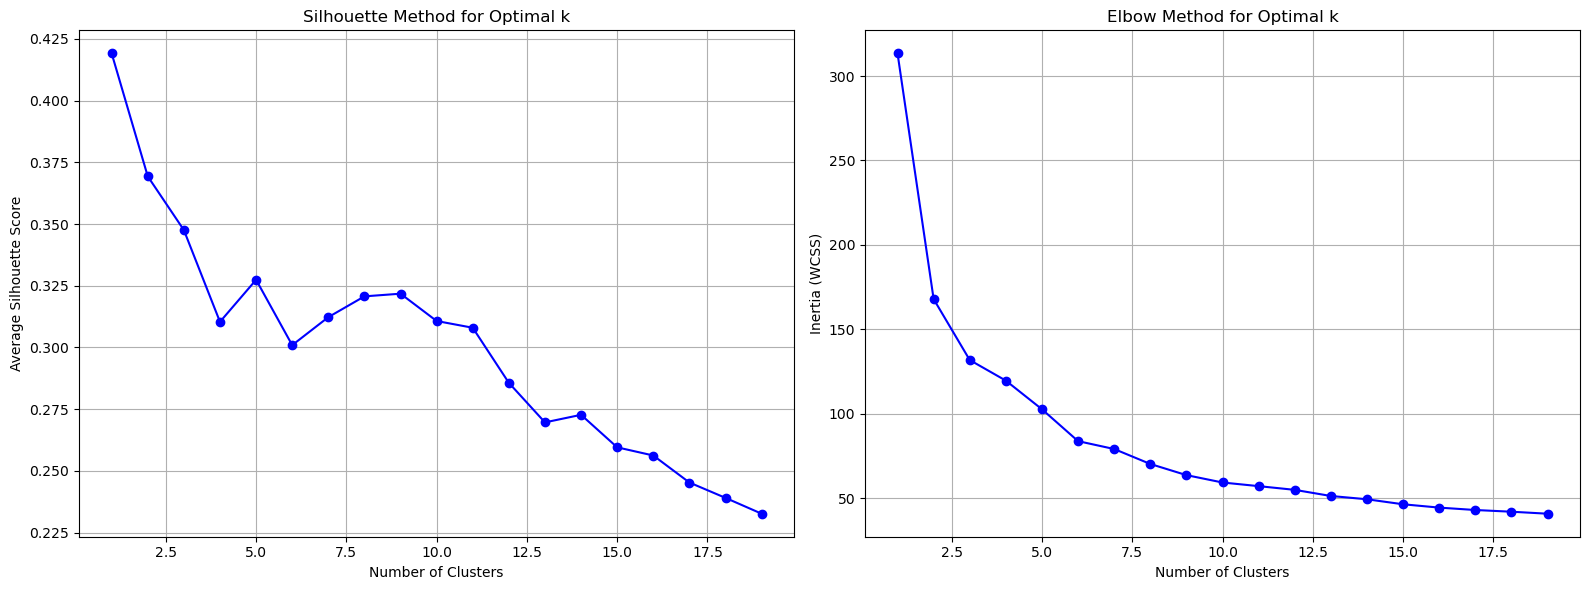

In [9]:
########### Finding Optimal Clusters ###########
# Silhouette Scores
num = 20
silhouette_scores = []
k_range = range(2, num+1)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(model_vectors_np)
    silhouette_avg = silhouette_score(model_vectors_np, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Inertia (WCSS)
inertias = []
k_range = range(1, num)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(model_vectors_np)
    inertias.append(kmeans.inertia_)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(k_range, silhouette_scores, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Average Silhouette Score')
ax1.set_title('Silhouette Method for Optimal k')
ax1.grid(True)
ax2.plot(k_range, inertias, 'bo-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Inertia (WCSS)')
ax2.set_title('Elbow Method for Optimal k')
ax2.grid(True)
plt.tight_layout()
plt.show()

## Distribution

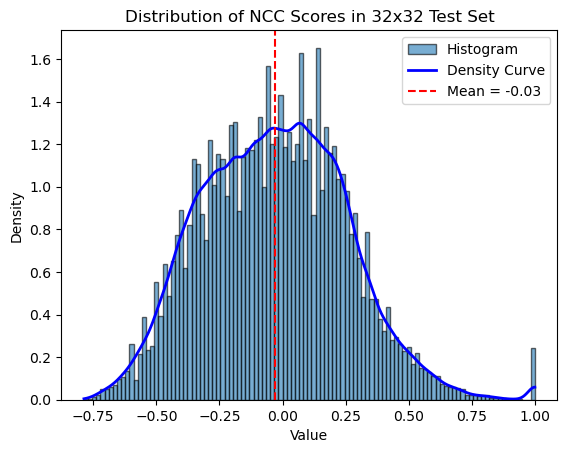

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

testSample = np.load('/home/jovyan/workspace-test1/VecRepV3/data/train_images_16x16.npy')
testSample = testSample[:500]
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
upper_triangle = matrixG[np.triu_indices_from(matrixG, k=0)]

mean_val = np.mean(upper_triangle)
density = gaussian_kde(upper_triangle)
x_vals = np.linspace(min(upper_triangle), max(upper_triangle), 500)
density_vals = density(x_vals)
plt.hist(upper_triangle, bins='auto', edgecolor='black', density=True, alpha=0.6, label='Histogram')
plt.plot(x_vals, density_vals, color='blue', linewidth=2, label='Density Curve')
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
plt.title("Distribution of NCC Scores in 32x32 Test Set")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


## Total parameters in model

In [35]:
dimensions = 256
model = models.SimpleCNN4(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                                              f'best_model_{imageType}_{dimensions}d_convlayer3.pt'), weights_only=True, map_location=torch.device('cpu')))
model.eval()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

total = count_params(model)
print(f"Total model params: {total}")

lpd_total = sum(count_params(getattr(model, f"lpd{i}")) for i in range(1, 5))
print(f"Total lpd1–lpd6 params: {lpd_total}")

conv_total = sum(count_params(getattr(model, f"conv{i}")) for i in range(1, 5))
print(f"Total conv1–conv6 params: {conv_total}")

bn_total = sum(count_params(getattr(model, f"bn{i}")) for i in range(1, 5))
print(f"Total bn1–bn6 params: {bn_total}")

fc_total = count_params(model.fc)
print(f"fc layer params: {fc_total}")

Total model params: 522816
Total lpd1–lpd6 params: 392160
Total conv1–conv6 params: 97152
Total bn1–bn6 params: 480
fc layer params: 33024


In [7]:
# -------------- for debugging -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 154
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than tolerance: 154

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.159